In [ ]:
# Install all required dependencies
!pip install tifffile scikit-image pillow opencv-python beautifulsoup4 matplotlib pandas torch tqdm scikit-learn

In [4]:
import tifffile
from skimage import io
from PIL import Image
import cv2
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch import nn
import torch.nn.functional as F

from glob import glob
import os.path as osp
import numpy as np
import random
from tqdm import tqdm

from sklearn.model_selection import train_test_split

ModuleNotFoundError: No module named 'skimage'

In [2]:
BASE_PATH='/kaggle/input/breast-cancer-cell-segmentation'
IMAGES_PATH = osp.join(BASE_PATH, 'Images')
LABELS_PATH = osp.join(BASE_PATH, 'Masks')

In [3]:
imgs_paths = glob(osp.join(IMAGES_PATH,"*.tif"))

In [4]:
masks_paths = [osp.join(LABELS_PATH, i.rsplit("/",1)[-1].split("_ccd")[0]+".TIF") for i in imgs_paths]

In [5]:
img_mask_tuples = list(zip(imgs_paths, masks_paths))

random.shuffle(img_mask_tuples)

train_tuples, test_tuples = train_test_split(img_mask_tuples)

In [6]:
def get_tiff_image(path, normalized=True,resize=(512, 512)):
    image = io.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (512, 512))
    if normalized:
        return image/255
    return image

In [7]:
class BCDataset(torch.utils.data.Dataset):
    
    def __init__(self, img_mask_tuples):
        self.img_mask_tuples = img_mask_tuples
        
    def __len__(self,):
        return len(self.img_mask_tuples)
    
    def __getitem__(self, idx):
        
        img_path, mask_path = self.img_mask_tuples[idx]
        
        image = get_tiff_image(img_path)
        mask = get_tiff_image(mask_path, normalized=False)
        mask[mask > 0] = 1
        
        return image,mask

In [8]:
train_dataset = BCDataset(train_tuples)
test_dataset = BCDataset(test_tuples)

In [9]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False)

In [10]:
import torch.nn.functional as F
class DoubleConv(nn.Module):
    

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.double_conv(x)
class Down(nn.Module):
    

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)
class Up(nn.Module):
    

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = UNet(n_channels=3, n_classes=1)
model.to(device);

In [12]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.02, momentum=0.5)

def dice_loss(inputs, target):
    inputs = torch.sigmoid(inputs)
    smooth = 1.
    iflat = inputs.contiguous().view(-1)
    tflat = target.contiguous().view(-1)
    intersection = (iflat * tflat).sum()
    loss = 1 - ((2. * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))
    return loss

In [13]:
for epoch in tqdm(range(100)):
    for images, labels in iter(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        images = images.permute(0,3,2,1).float()
        labels = labels.permute(0,3,2,1).float()
        labels = labels.sum(1,keepdim=True).bool().float()

        output = model(images)
        
        loss = criterion(output, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

100%|██████████| 100/100 [14:18<00:00,  8.58s/it]


In [14]:
output = torch.sigmoid(output)
output[output >= 0.5] = 1
output[output < 0.5] = 0

image


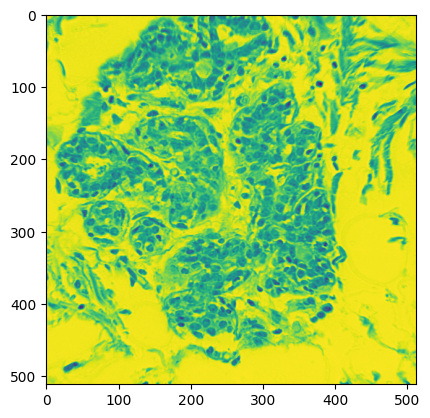

output


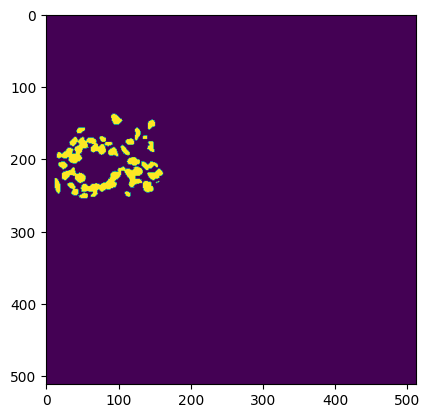

label


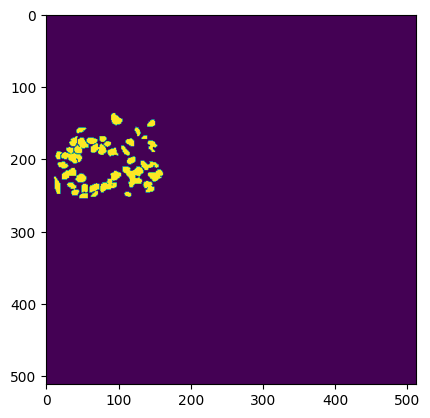

In [15]:
batch_index=0
print("image")
plt.imshow(images.cpu().detach().numpy()[batch_index,0])
plt.show()
print("output")
plt.imshow(output.cpu().detach().numpy()[batch_index,0])
plt.show()
print("label")
plt.imshow(labels.cpu().detach().numpy()[batch_index,0])
plt.show()

image


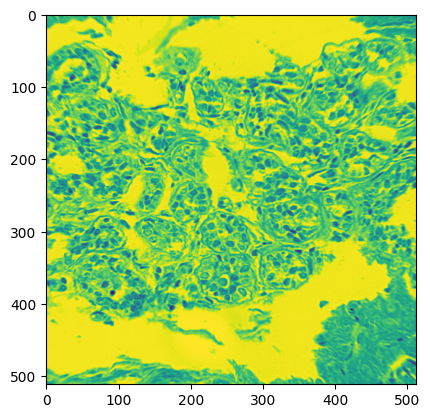

output


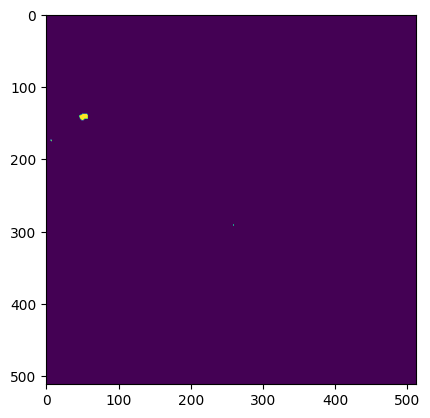

label


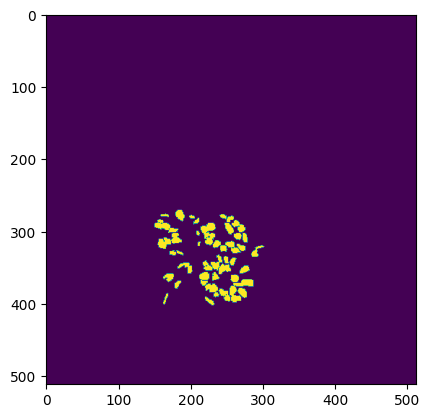

In [16]:

model.eval()
with torch.no_grad():
    for images, labels in iter(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        images = images.permute(0, 3, 2, 1).float()
        labels = labels.permute(0, 3, 2, 1).float()
        labels = labels.sum(1, keepdim=True).bool().float()
        output = model(images)
        
        # Post-processing for visualization
        output = torch.sigmoid(output)
        output[output >= 0.5] = 1
        output[output < 0.5] = 0
        
        batch_index = 0
        print("image")
        plt.imshow(images.cpu().detach().numpy()[batch_index, 0])
        plt.show()
        print("output")
        plt.imshow(output.cpu().detach().numpy()[batch_index, 0])
        plt.show()
        print("label")
        plt.imshow(labels.cpu().detach().numpy()[batch_index, 0])
        plt.show()
        break 
